# Image Generation

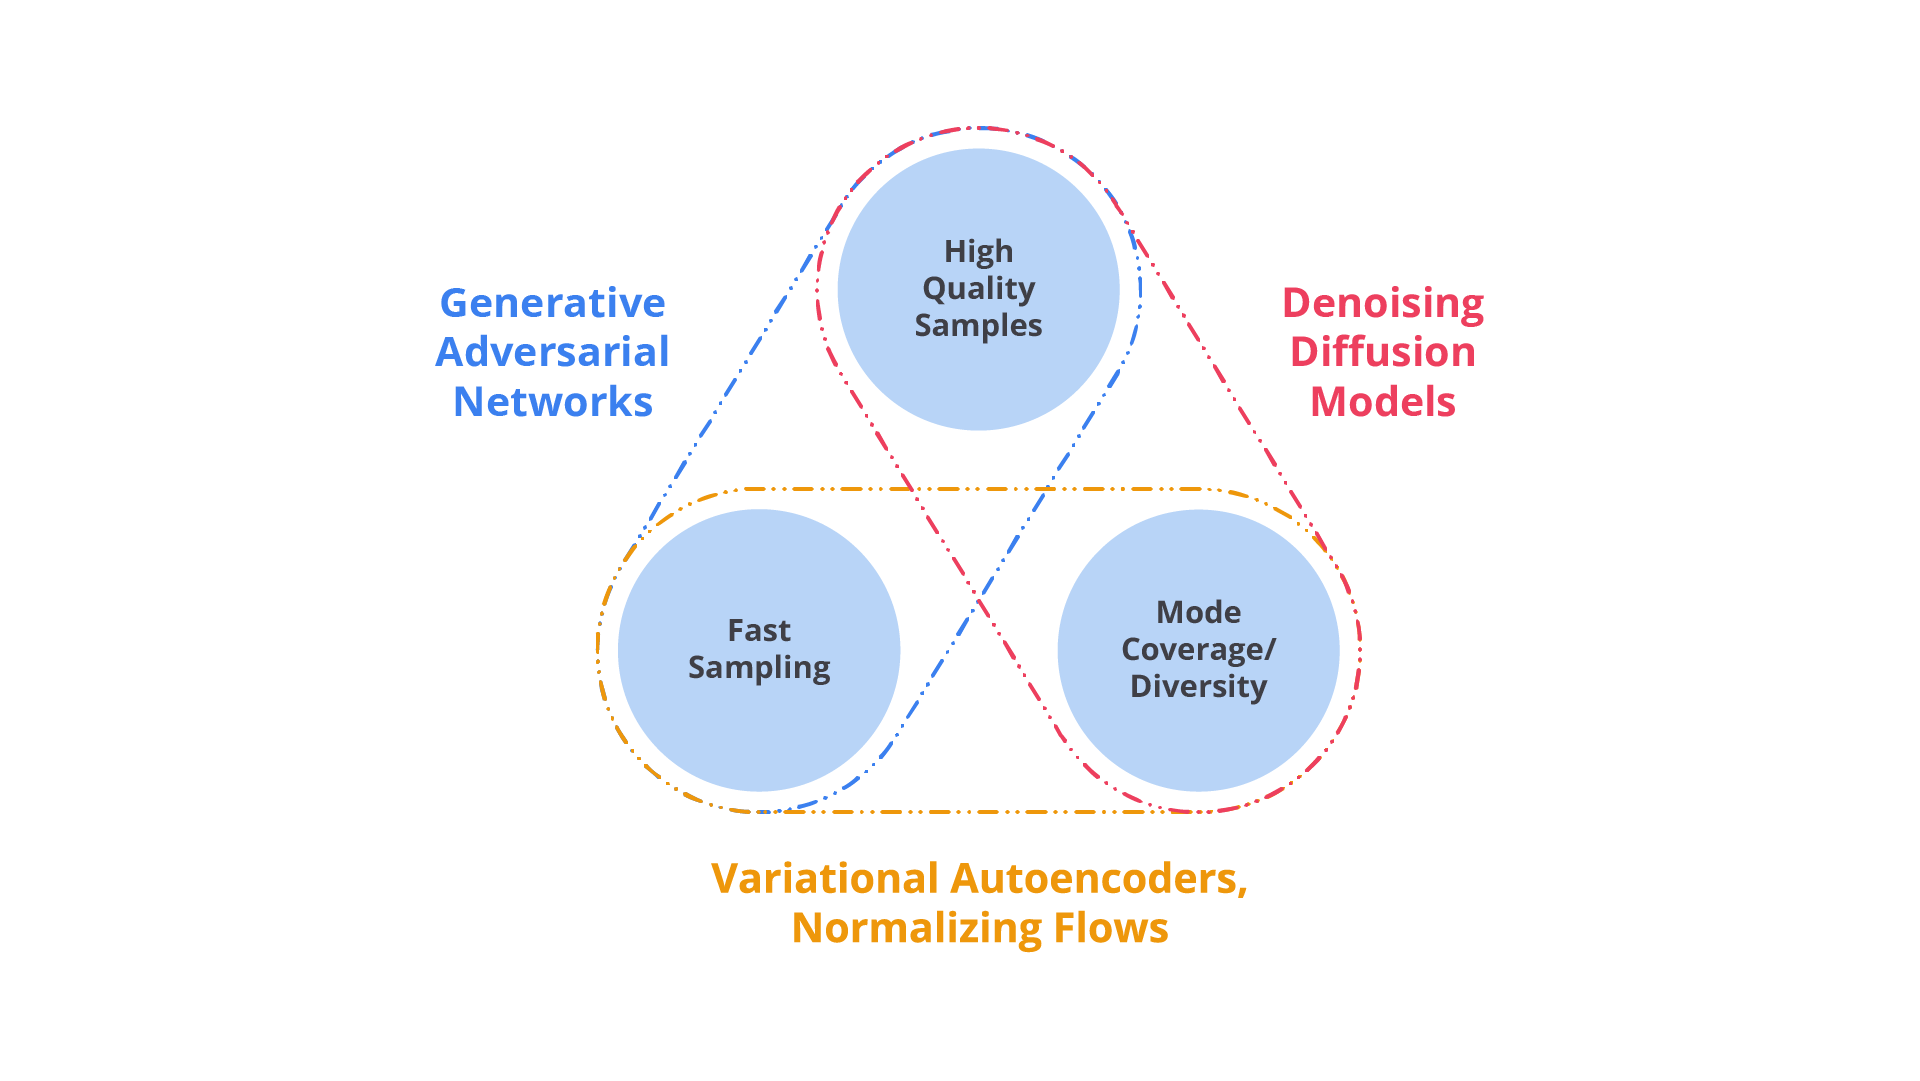

GAN, VAE, dan Diffusion Models adalah tiga model Generative AI yang ampuh dengan kelebihan dan kekurangan masing-masing. Pilihan model tergantung pada kebutuhan dan permasalahan yang ingin diselesaikan. 
- GAN cocok untuk menghasilkan data yang sangat realistis,  
- VAE cocok untuk menghasilkan data yang konsisten dan koheren.  
- Diffusion Models menawarkan keseimbangan antara kualitas dan efisiensi pelatihan.

## Variational Autoencoder (VAE)

VAE menggunakan konsep autoencoder sebagai inti dari kinerjanya, autoencoder berperan sebagai blok bangunan fundamental yang memungkinkan model untuk mempelajari representasi laten data. Autoencoder adalah jenis jaringan saraf yang terdiri dari dua bagian utama, yaitu encoder dan decoder.

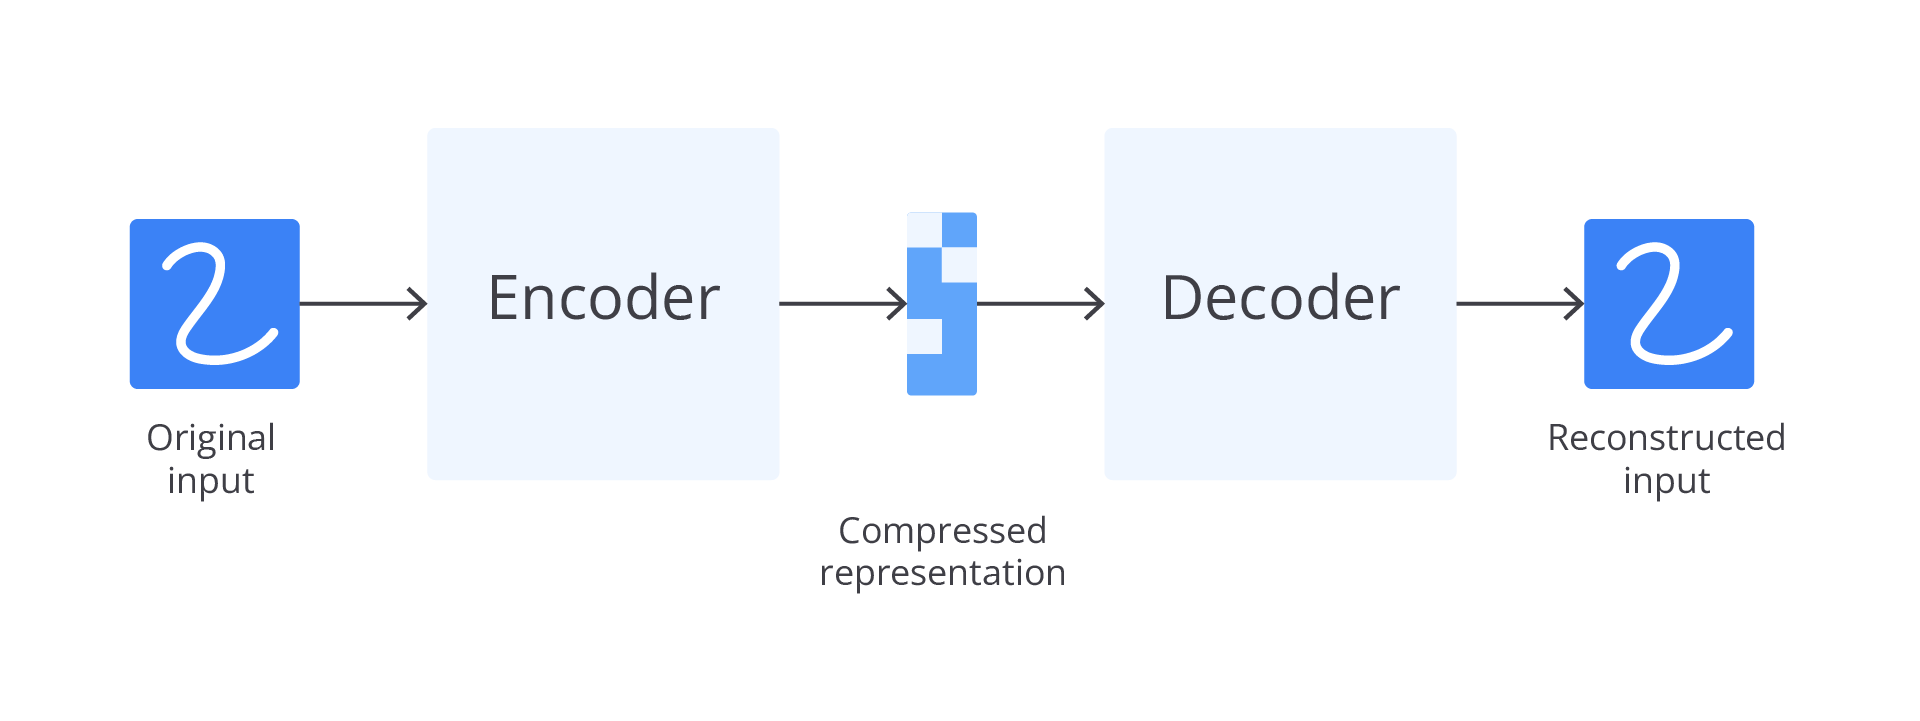

Secara singkat encoder bertugas untuk mengambil data masukan (misalnya, gambar) dan mengonversinya menjadi representasi laten yang lebih kecil. Representasi laten ini menangkap informasi penting dari data asli. Di lain sisi, decoder menerima representasi laten dari encoder dan mencoba merekonstruksi data asli dari representasi tersebut. 

Encoder dan decoder dilatih secara bersamaan untuk meminimalkan perbedaan antara data asli dan data yang direkonstruksi. Ini memastikan decoder dapat merekonstruksi data dengan baik dari representasi laten yang dihasilkan oleh encoder.

Selain rekonstruksi data, VAE menggunakan regularisasi untuk mendorong representasi laten menjadi lebih informatif. Ini penting karena representasi laten tidak hanya harus memungkinkan rekonstruksi data, tetapi juga berguna untuk menghasilkan data baru.

**Catatan**:
- Variabel Laten: variabel tersembunyi atau acak yang, meskipun tidak dapat diamati secara langsung, pada dasarnya menginformasikan cara data didistribusikan.
- Representasi Laten: kode yang muncul dari lapisan encoder kemudian dimasukkan ke dalam decoder.


Perbedaan di atas membuat arsitektur diagram VAE memiliki sedikit perbedaan dari autoencoder dasar. Dalam Variational Autoencoders (VAEs),** z_mean dan z_log_var** adalah variabel penting yang terkait dengan representasi laten data. Representasi laten ini merupakan representasi terkompresi dari data asli yang digunakan VAE untuk berbagai fungsinya, seperti rekonstruksi data dan generasi data baru. 
-  z_mean merupakan representasi rata-rata dari distribusi probabilitas representasi laten. Variabel ini merupakan vector numerik yang mewakili nilai "pusat" dari representasi laten yang mungkin dihasilkan oleh VAE. Selain itu, fungsi dari z_mean juga untuk menunjukkan kecenderungan atau bias representasi laten.

- z_log_var yang merupakan representasi logaritma varians dari distribusi probabilitas representasi laten. Nilai yang lebih tinggi dalam z_log_var menunjukkan bahwa representasi laten dapat tersebar lebih luas, sedangkan nilai yang lebih rendah menunjukkan representasi laten yang lebih terkonsentrasi di sekitar z_mean.

Kedua variabel di atas memiliki peran penting untuk menghasilkan data baru. VAE dapat menghasilkan data baru dengan mengambil sampel acak dari distribusi probabilitas representasi laten yang didefinisikan oleh z_mean dan z_log_var. Variasi dalam representasi laten (ditunjukkan oleh z_log_var) memungkinkan VAE untuk menghasilkan data baru yang beragam. Dalam beberapa kasus, z_mean dan z_log_var dapat diinterpretasikan untuk memahami apa yang diwakili oleh dimensi tertentu dalam representasi laten.

### Import library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
    
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)
    
from scipy.stats import norm

2025-04-07 12:59:10.940741: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 12:59:11.003942: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 12:59:11.058396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744005551.122359   19523 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744005551.141212   19523 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744005551.203601   19523 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Parameter initialization

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

### Data loading

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 7us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Preprocessing

In [4]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs
    
x_train = preprocess(x_train)
x_test = preprocess(x_test)

### Sampling layer

In [5]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

- class Sampling(layers.Layer): baris ini mendeklarasikan sebuah class bernama Sampling yang mewarisi dari class layers.Layer di TensorFlow. Ini menandakan bahwa Sampling adalah sebuah lapisan kustom yang bisa kita gunakan dalam model kita.
- def call(self, inputs): method call ini didefinisikan untuk menentukan bagaimana lapisan ini memproses input dan menghasilkan output. Fungsi call ini akan dipanggil setiap kali lapisan ini digunakan dalam model.
- z_mean, z_log_var = inputs: baris ini mengambil input dari lapisan sebelumnya. Biasanya dalam VAE, input akan terdiri dari dua tensor:
    - z_mean: merepresentasikan mean (rata-rata) dari latent space.
    - z_log_var: merepresentasikan log variance (log varians) dari latent space.
- batch = tf.shape(z_mean)[0]: menyimpan jumlah sampel dalam batch.
- dim = tf.shape(z_mean)[1]: menyimpan dimensi dari latent space (biasanya jumlah neuron di lapisan latent).
- epsilon = K.random_normal(shape=(batch, dim)): baris ini menggunakan fungsi K.random_normal dari library Keras untuk menghasilkan noise acak. Noise ini berdistribusi normal dengan mean 0 dan variance 1. Sedangkan shape=(batch, dim) memastikan noise memiliki ukuran yang sama dengan z_mean dan z_log_var.
- tf.exp(0.5 * z_log_var): digunakan untuk menghitung standard deviation dari latent space karena varians bernilai kuadrat dari standar deviasi.
- epsilon * standard_deviation: menambahkan noise acak yang sudah diskalakan oleh standar deviasi ke z_mean.

Singkatnya lapisan Sampling di atas mengambil mean dan log variance dari latent space, kemudian menggunakan noise acak untuk menghasilkan sampel acak yang mewakili distribusi probabilitas di latent space.

### ANN

In [6]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  
 
x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name="z_mean")(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
 
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

2025-04-07 13:09:17.616389: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)
    
decoder = models.Model(decoder_input, decoder_output)

In [9]:
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### VAE

In [10]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss
    
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
    
        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]
    
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA
            * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3))
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss
    
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

**Catatan**:

Gradient Tape adalah sebuah mekanisme yang memungkinkan komputasi gradien berdasarkan komputasi yang dijalankan selama forward pass sebuah model. Untuk menggunakannya, Anda perlu membungkus kode yang melakukan operasi yang ingin dibedakan dalam konteks tf.GradientTape(). Setelah menghitung nilai operasi, Anda dapat menghitung gradien dari fungsi kerugian sehubungan dengan beberapa variabel dengan memanggil tape.gradient(). Gradien kemudian dapat digunakan untuk memperbarui variabel dengan pengoptimal

### Training

In [12]:
vae = VAE(encoder, decoder)
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)
    
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")
    
vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/5


2025-04-07 13:13:21.738882: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 245760000 exceeds 10% of free system memory.


600/600 ━━━━━━━━━━━━━━━━━━━━ 362s 588ms/step - kl_loss: 3.4607 - reconstruction_loss: 201.4249 - total_loss: 204.8856 - val_kl_loss: 4.8557 - val_loss: 144.2330 - val_reconstruction_loss: 139.3773
Epoch 2/5


/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/genAI-venv/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


600/600 ━━━━━━━━━━━━━━━━━━━━ 328s 547ms/step - kl_loss: 4.7977 - reconstruction_loss: 132.7889 - total_loss: 137.5866 - val_kl_loss: 4.9344 - val_loss: 142.7394 - val_reconstruction_loss: 137.8050
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 335s 559ms/step - kl_loss: 4.8774 - reconstruction_loss: 130.6810 - total_loss: 135.5584 - val_kl_loss: 5.0103 - val_loss: 138.9661 - val_reconstruction_loss: 133.9559
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 350s 583ms/step - kl_loss: 4.9355 - reconstruction_loss: 129.5049 - total_loss: 134.4404 - val_kl_loss: 5.0710 - val_loss: 137.6799 - val_reconstruction_loss: 132.6089
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 459s 766ms/step - kl_loss: 5.0108 - reconstruction_loss: 128.5707 - total_loss: 133.5814 - val_kl_loss: 5.1805 - val_loss: 136.6505 - val_reconstruction_loss: 131.4700


Selanjutnya, kita dapat menggunakan encoder untuk mengodekan gambar dalam pengujian dan memplot nilai z_mean dalam ruang laten. Kita juga dapat mengambil sampel dari distribusi normal untuk menghasilkan titik-titik di ruang laten dan menggunakan decoder untuk menguraikan titik-titik ini kembali ke dalam ruang piksel untuk melihat kinerja VAE.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


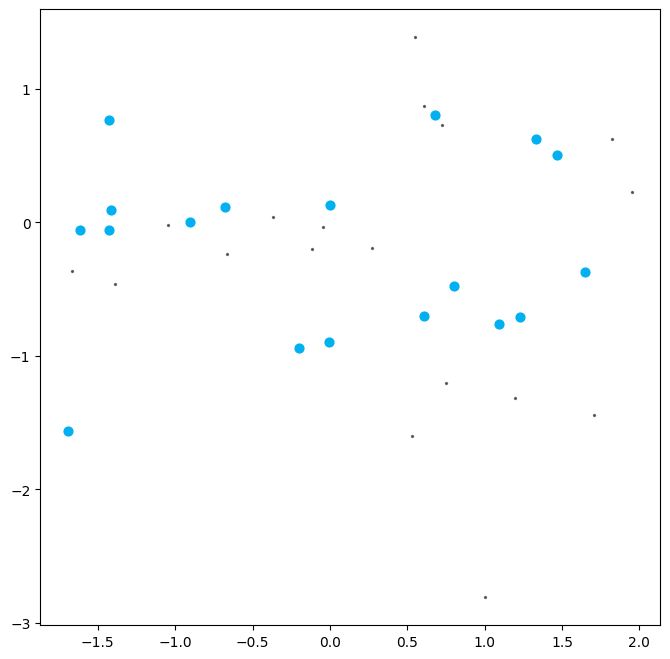

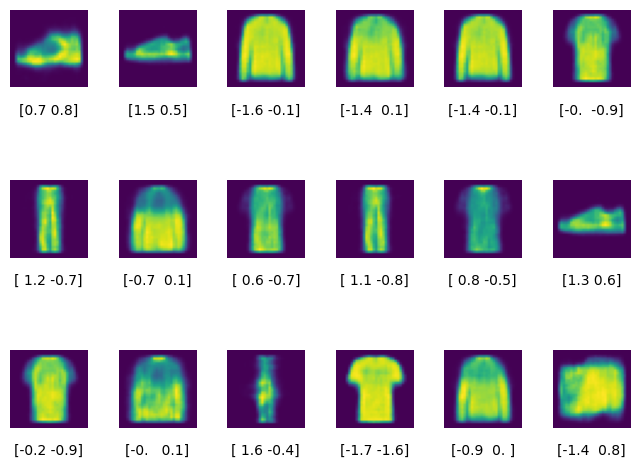

In [17]:
example_images = x_test[:18]


# Encode citra
z_mean, z_var, z = encoder.predict(example_images)
    
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))
    
# Decode sampel poin
reconstructions = decoder.predict(z_sample)
    
# Konversi nilai embedding menjadi p_values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)
    
# Membuat plot
figsize = 8
plt.figure(figsize=(figsize, figsize))
    
# Original Embeddings
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=2)
    
# Ruang laten
plt.scatter(z_sample[:, 0], z_sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()
    
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    # ax.imshow(reconstructions[i, :, :], cmap="Greys")
    ax.imshow(reconstructions[i])

## Generative Adversarial Network (GAN)

terdiri dari dua jaringan saraf yang berkompetisi satu sama lain, yaitu :
- Generator : mencoba mengubah noise acak menjadi sebuah gambar baru
- Discriminator : mencoba memprediksi apakah gambar tersebut asli atau bukan

Generator akan menghasilkan gambar dan diskriminator memprediksi secara acak. 
Kunci dari metode GAN terletak pada bagaimana kita melatih kedua jaringan tersebut (generator dan diskriminator) sehingga ketika generator menjadi lebih mahir dalam mengelabui diskriminator, diskriminator harus beradaptasi untuk mempertahankan kemampuannya dalam mengidentifikasi dengan benar. Hal ini mendorong generator untuk menemukan cara-cara baru untuk menipu diskriminator, dan siklus ini terus berlanjut. 

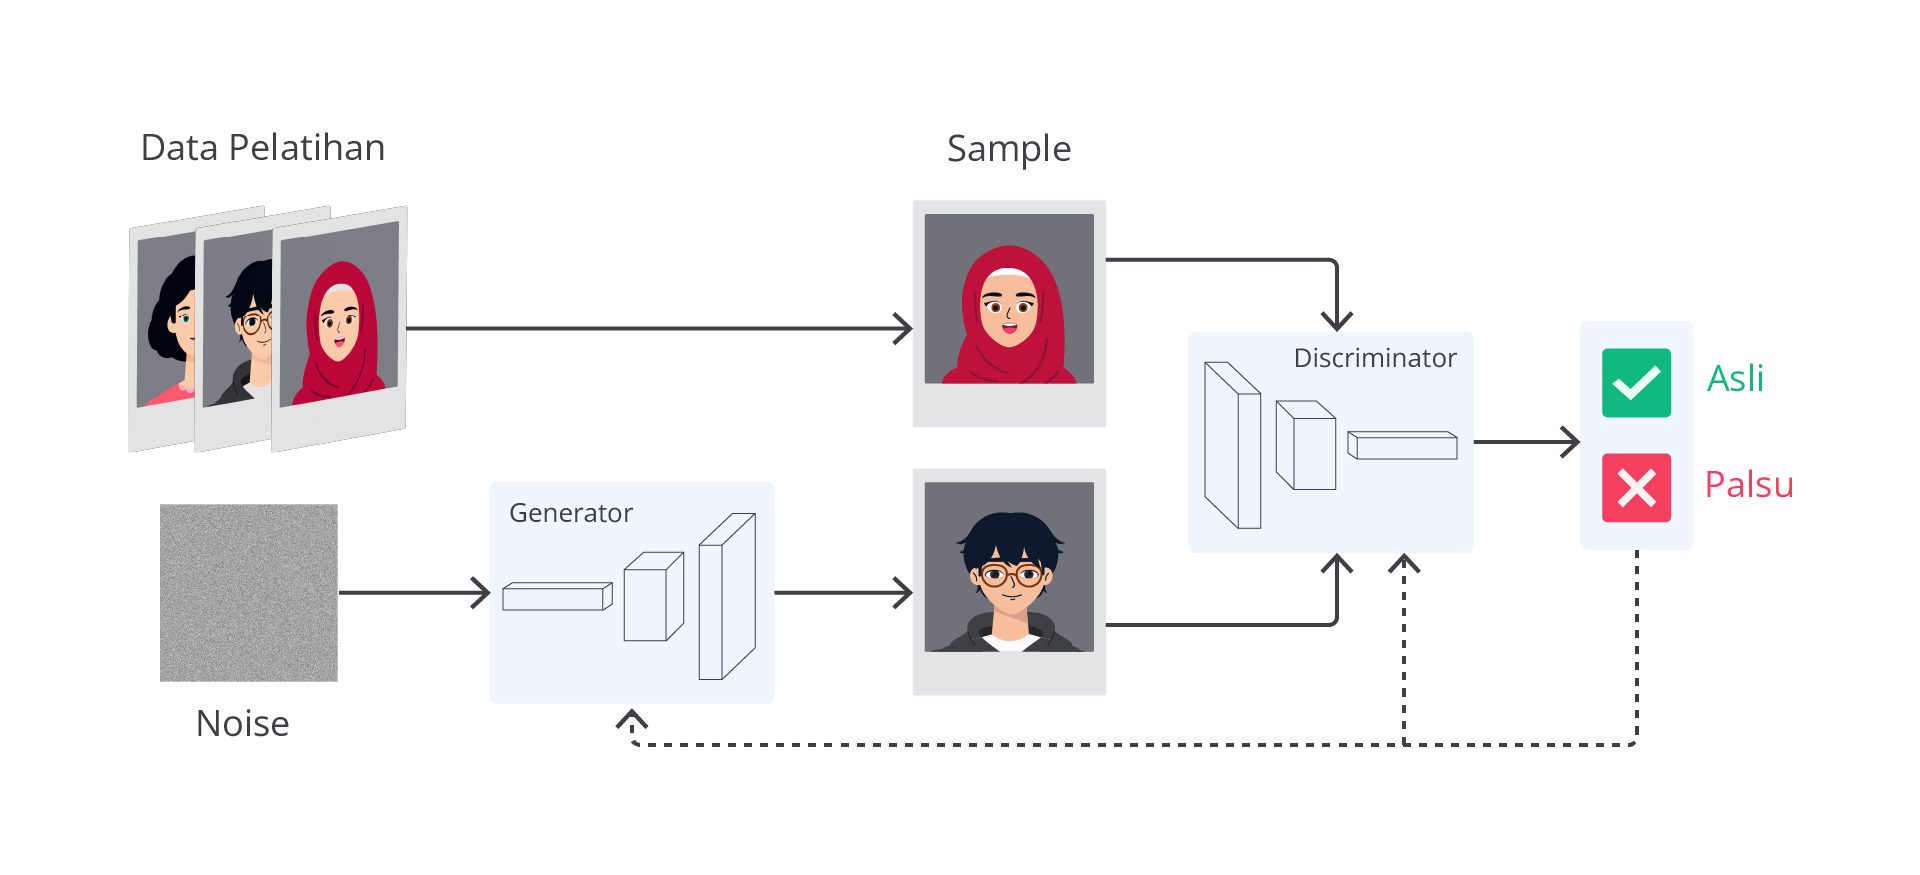

Tujuan utama persaingan antara generator dan diskriminator adalah untuk menghasilkan data yang sangat realistis seiring berjalannya waktu, keduanya saling “menipu” untuk kebaikan bersama. 

**Komponen utama dari GAN**: 

- Generator
    - Generator bertugas untuk menghasilkan data baru yang menyerupai data pelatihan.
    - Mengambil input berupa noise acak (biasanya vector dari distribusi normal) dan mengubahnya menjadi data yang menyerupai distribusi data pelatihan.
    - Tujuannya adalah untuk "menipu" Discriminator sehingga tidak dapat membedakan antara data nyata dan data palsu yang dihasilkan.
- Discriminator
    - Discriminator bertugas untuk membedakan antara data nyata (dari dataset pelatihan) dan data palsu (dari Generator).
    - Mengambil input berupa data (baik nyata maupun palsu) dan menghasilkan probabilitas yang menunjukkan apakah data tersebut nyata atau palsu.
    - Tujuannya adalah untuk membuat data baru dengan akurat agar dapat diklasifikasikan sebagai data nyata atau palsu.

Cara kerja GAN secara singkat adalah mengubah gambar dari satu domain ke domain lain, seperti mengubah foto siang menjadi malam atau mengubah tipe penulisan angka.

### Import library

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

### Hyperparameter initialization

In [32]:
latent_dim = 100
hidden_dim = 256
image_dim = 28 * 28
batch_size = 64
learning_rate = 0.0002
num_epochs = 50

- latent_dim = 100: 
    - hyperparameter ini menentukan dimensi dari ruang laten, yaitu dimensi dari input noise yang diberikan kepada Generator. 
    - Noise dengan nilai acak ini akan diubah oleh Generator menjadi data yang menyerupai data pelatihan. 
    - Biasanya, nilai ini dipilih cukup besar untuk memungkinkan Generator membuat representasi yang kompleks, tetapi tidak terlalu besar sehingga memperlambat pelatihan.
- hidden_dim = 256: 
    - jumlah neuron dalam layer tersembunyi (hidden layers) dari model Generator dan Discriminator. 
    - Jumlah neuron dalam layer tersembunyi mempengaruhi kapasitas model untuk menangkap pola-pola dalam data. Nilai ini harus cukup besar untuk menangkap kerumitan data, tetapi tidak terlalu besar untuk menghindari overfitting dan penggunaan memori yang berlebihan.
- image_dim = 28 * 28: 
    - dimensi dari gambar input yang akan digunakan dalam model. 
    - Dalam konteks dataset MNIST, gambar memiliki ukuran 28x28 piksel, jadi image_dim adalah 784 (28 * 28). Ini merepresentasikan jumlah fitur dalam satu gambar yang akan dimasukkan ke dalam Discriminator.
- batch_size = 64: 
    - jumlah sampel data yang akan diproses dalam satu batch selama pelatihan. 
    - Menggunakan batch size memungkinkan pelatihan lebih efisien dengan memanfaatkan komputasi paralel. 
    - Batch size yang lebih besar cenderung memberikan estimasi gradien yang lebih stabil, tetapi memerlukan lebih banyak memori.
- learning_rate = 0.0002: 
    - laju pembelajaran (learning rate), menghitung seberapa besar langkah yang diambil model dalam memperbarui parameter selama pelatihan. 
    - Learning rate tinggi dapat mempercepat pelatihan, tetapi jika terlalu tinggi dapat menyebabkan pelatihan tidak stabil atau gagal menemukan solusi optimal.
    -Sebaliknya learning rate yang terlalu rendah akan membuat pelatihan lambat dan mungkin terjebak di minimum lokal.
- num_epochs = 50: 
    - jumlah iterasi penuh selama pelatihan. 
    - Semakin banyak jumlah epoch, semakin lama juga model akan dilatih sehingga kinerja model akan meningkat sampai titik tertentu yang dapat menyebabkan overfitting. 
    - Pilihan jumlah epoch yang tepat bergantung pada ukuran dan kompleksitas dataset, serta kapasitas model.


### Transformasi

In [33]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9.91M/9.91M [18:06<00:00, 9.12kB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 43.9kB/s]
100%|██████████| 1.65M/1.65M [02:32<00:00, 10.8kB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0kB/s]


- transforms.Compose([...]): menggabungkan beberapa data menjadi satu yang akan diterapkan secara berurutan pada setiap data.
- transforms.ToTensor(): mengubah gambar dalam bentuk PIL Image atau numpy array menjadi tensor PyTorch. Selain itu, juga mengubah skala piksel dari rentang [0, 255] ke [0.0, 1.0].
- transforms.Normalize((0.5,), (0.5,)): menormalisasi tensor gambar dengan rata-rata 0.5 dan standar deviasi 0.5 untuk setiap saluran. Dalam kasus dataset MNIST, yang bersifat grayscale, ini dilakukan untuk membuat data memiliki distribusi dengan rata-rata 0 dan standar deviasi 1. Transformasi ini mengubah rentang piksel dari [0.0, 1.0] ke [-1.0, 1.0].
- datasets.MNIST(...): memanggil dataset MNIST.
- root='./data': menentukan direktori di mana dataset akan disimpan atau diunduh.
- train=True: menentukan bahwa dataset yang dimuat adalah bagian pelatihan (training set) dari MNIST.
- transform=transform: menerapkan transformasi yang telah didefinisikan sebelumnya pada setiap gambar dalam dataset.
- download=True: mengunduh dataset jika belum tersedia di direktori yang ditentukan.
- torch.utils.data.DataLoader(...): menginisialisasi DataLoader.
- dataset=train_dataset: menentukan dataset yang akan dimuat oleh DataLoader.
- batch_size=batch_size: menentukan jumlah sampel per batch. Nilai batch_size telah ditetapkan sebelumnya menjadi 64.
- shuffle=True: mengacak data di setiap epoch sehingga model tidak melihat data dalam urutan yang sama setiap kali. Ini membantu dalam meningkatkan kinerja pelatihan dengan mencegah model belajar urutan data.

### Generator and Discriminator

In [34]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, image_dim),
            nn.Tanh()
        )
    
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

- class Generator(nn.Module): 
    - kelas Generator ini merupakan subclass dari nn.Module, yang merupakan kelas dasar untuk semua jaringan saraf dalam PyTorch. 
    - Dengan mewarisi sifat dari nn.Module, kelas ini dapat memanfaatkan semua fungsionalitas yang ada dalam PyTorch untuk membangun dan melatih model jaringan saraf.
- def __init__(self): 
    - metode inisialisasi atau konstruktor untuk kelas Generator.
- super(Generator, self).__init__(): 
    - memanggil konstruktor dari kelas induk (nn.Module) untuk memastikan semua properti dan metode dari nn.Module diinisialisasi dengan benar.
- self.model = nn.Sequential(...): 
    - mendefinisikan jaringan saraf sebagai lapisan sequential yang bertugas untuk membangun jaringan lapis demi lapis.
- nn.Linear(latent_dim, hidden_dim): 
    - lapisan linear (fully connected) pertama yang mengambil input dari ruang laten (latent_dim) dan memetakan ke ruang berdimensi hidden_dim. 
    - latent_dim biasanya adalah dimensi dari input noise.
- nn.ReLU(True): 
    - fungsi aktivasi ReLU (Rectified Linear Unit) yang diterapkan setelah lapisan linear pertama. 
    - True menunjukkan bahwa aktivasi dilakukan secara in-place untuk menghemat memori.
- nn.Linear(hidden_dim, hidden_dim): 
    - lapisan linear kedua yang tetap memiliki dimensi hidden_dim. 
    - Ini menambahkan kompleksitas ke jaringan dengan lebih banyak parameter untuk dipelajari.
- nn.ReLU(True): 
    - fungsi aktivasi ReLU kedua.
- nn.Linear(hidden_dim, image_dim): 
    - lapisan linear ketiga yang mengambil input dari ruang berdimensi hidden_dim dan memetakan ke dimensi gambar (image_dim). 
    - image_dim biasanya adalah jumlah piksel dalam gambar, misalnya, untuk gambar 28x28 piksel, image_dim adalah 784.
- nn.Tanh(): 
    - fungsi aktivasi Tanh yang diterapkan setelah lapisan linear terakhir. 
    - Fungsi Tanh membatasi output ke rentang [-1, 1], yang sesuai dengan rentang nilai piksel gambar yang dinormalisasi.
- def forward(self, z): 
    - metode forward ini mendefinisikan aliran data melalui jaringan ketika input diberikan. 
    - Metode ini harus diimplementasikan kepada semua subclass nn.Module dan menentukan bagaimana input diteruskan melalui fully connected layer.
- img = self.model(z): 
    - input z, yang merupakan tensor noise acak dari ruang laten dengan dimensi latent_dim, diteruskan melalui jaringan yang didefinisikan dalam self.model. 
    - Hasilnya adalah tensor dengan dimensi image_dim.
- img = img.view(img.size(0), 1, 28, 28): 
    - mengubah bentuk tensor img dari bentuk (batch_size, image_dim) menjadi (batch_size, 1, 28, 28). 
    - img.size(0) adalah ukuran batch (jumlah gambar dalam satu batch). 
    - Bentuk akhir (1, 28, 28) menunjukkan bahwa gambar tersebut memiliki satu saluran (grayscale) dengan resolusi 28x28 piksel.
- return img: 
    - mengembalikan tensor gambar yang dihasilkan oleh Generator.


Kelas Generator ini bertanggung jawab untuk mengambil input noise acak dari ruang laten dan menghasilkan gambar yang realistis. Struktur jaringan yang dibangun menggunakan beberapa lapisan linear dan fungsi aktivasi ReLU, diakhiri dengan fungsi aktivasi Tanh untuk memastikan output berada dalam rentang yang diinginkan. Metode forward mendefinisikan bagaimana input diteruskan melalui jaringan neuron dan mengubah bentuk output agar sesuai dengan dimensi gambar yang diinginkan.

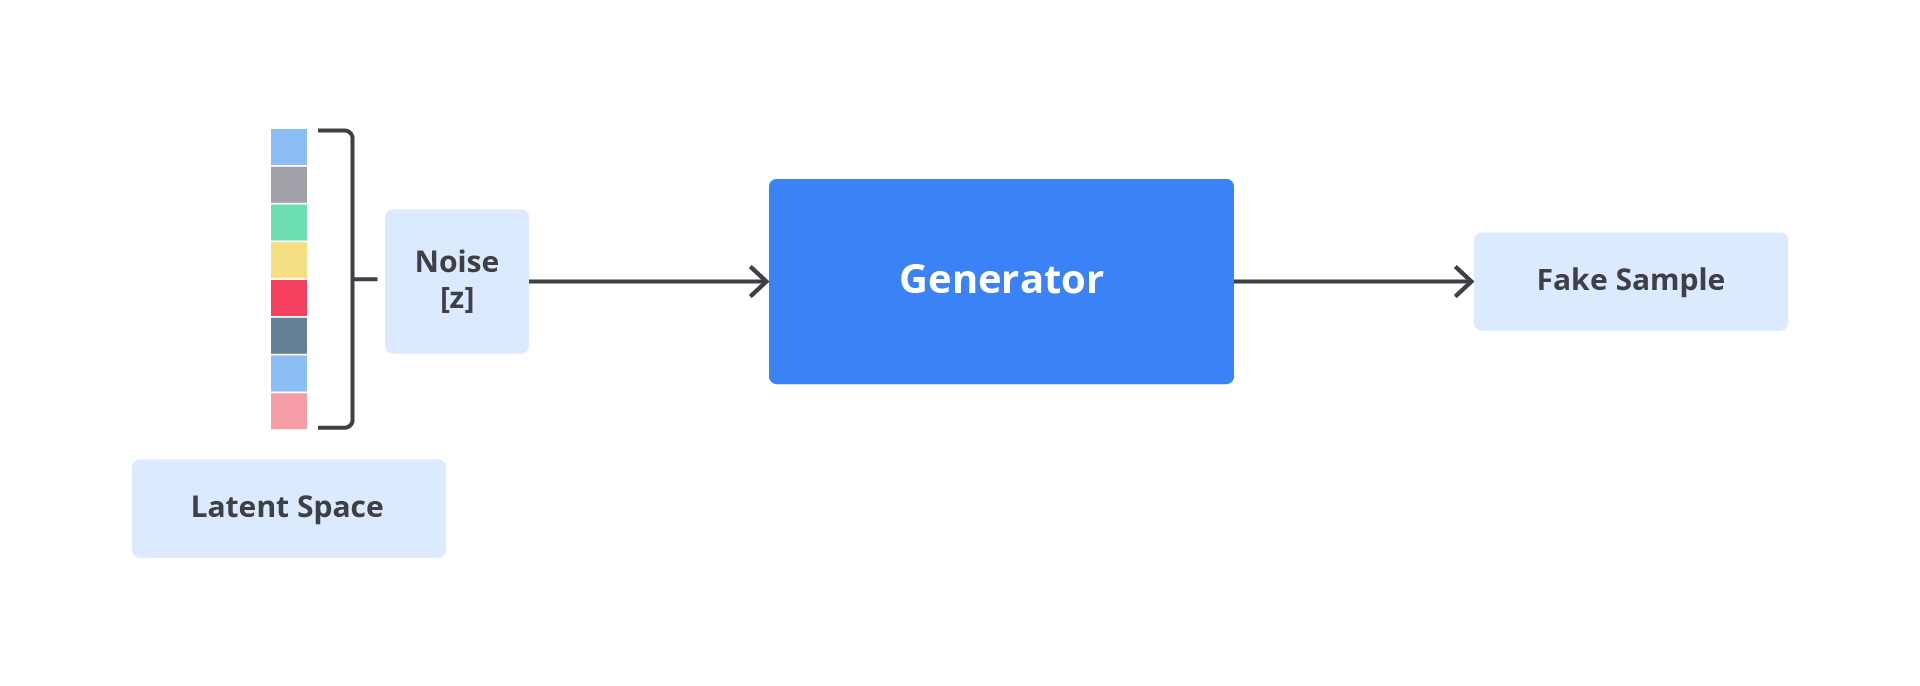

In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

- class Discriminator(nn.Module): 
    - kelas Discriminator ini merupakan subclass dari nn.Module yang merupakan kelas dasar untuk semua jaringan saraf dalam PyTorch. 
    - Dengan mewarisi sifat nn.Module, kelas ini dapat memanfaatkan semua fungsionalitas yang ada dalam PyTorch untuk membangun dan melatih model jaringan saraf.
- def __init__(self): 
    - inisialisasi konstruktor untuk kelas Discriminator.
- super(Discriminator, self).__init__(): 
    - memanggil konstruktor dari kelas induk (nn.Module) untuk memastikan semua properti dan metode dari nn.Module diinisialisasi dengan benar.
- self.model = nn.Sequential(...): 
    - mendefinisikan jaringan saraf sebagai lapisan Sequential (berurutan) menggunakan nn.Sequential. 
- nn.Linear(image_dim, hidden_dim): 
    - lapisan linear (fully connected) pertama yang mengambil input berupa gambar yang telah melalui proses flattening (datar) dengan dimensi image_dim dan memetakan ke ruang berdimensi hidden_dim. image_dim.
- nn.LeakyReLU(0.2, inplace=True): 
    - fungsi aktivasi Leaky ReLU dengan kemiringan negatif sebesar 0.2. 
    - inplace=True berarti operasi ini dilakukan di tempat, menghemat memori dengan menggantikan nilai input dengan outputnya.
- nn.Linear(hidden_dim, hidden_dim): 
    - lapisan linear kedua yang tetap memiliki dimensi hidden_dim. 
    - Fungsinya untuk menambahkan kompleksitas ke jaringan dengan lebih banyak parameter untuk dipelajari.
- nn.LeakyReLU(0.2, inplace=True): 
    - fungsi aktivasi Leaky ReLU kedua dengan parameter yang sama.
- nn.Linear(hidden_dim, 1): 
    - lapisan linear ketiga yang memetakan dari ruang berdimensi hidden_dim ke sebuah nilai tunggal yang menunjukkan skor validitas (seberapa asli atau palsu gambar tersebut).
- nn.Sigmoid(): 
    - fungsi aktivasi Sigmoid berfungsi untuk membatasi output ke rentang [0, 1], atau bisa diinterpretasikan sebagai probabilitas.
- def forward(self, img): 
    - fungsi forward ini bertugas untuk memastikan aliran data ketika input diberikan. 
- img_flat = img.view(img.size(0), -1): 
    - mengubah bentuk tensor gambar img dari bentuk (batch_size, 1, 28, 28) menjadi bentuk (batch_size, image_dim), di mana image_dim adalah jumlah piksel dalam gambar (misalnya, 784 untuk gambar 28x28 piksel). 
    - Kode ini bertugas untuk memastikan gambar dapat dikirimkan ke lapisan linear pertama.
- validity = self.model(img_flat): 
    - input yang telah melalui proses flattening (mengurangi dimensi) diteruskan melalui jaringan yang didefinisikan dalam self.model. 
    - Hasilnya adalah tensor dengan satu nilai per gambar yang menunjukkan skor validitas (kemungkinan bahwa gambar tersebut asli atau palsu).
- return validity: 
    - menghasilkan tensor yang berisi skor validitas untuk setiap gambar pada satu batch. 
    - Skor ini menunjukkan apakah gambar tersebut dianggap asli (nilai mendekati 1) atau palsu (nilai mendekati 0).


Kelas Discriminator di atas bertanggung jawab untuk mengambil gambar sebagai input dan menghasilkan skor yang menunjukkan seberapa asli gambar tersebut. Struktur jaringan menggunakan beberapa lapisan linear dan fungsi aktivasi Leaky ReLU, diakhiri dengan fungsi aktivasi Sigmoid untuk membatasi output ke rentang [0, 1]. 

Metode forward mendefinisikan bagaimana input akan diteruskan kepada jaringan neural network dan mengubah bentuk input agar sesuai dengan dimensi yang diinginkan. Dengan cara ini, Discriminator dilatih untuk membedakan antara gambar asli dan gambar palsu yang dihasilkan oleh Generator.

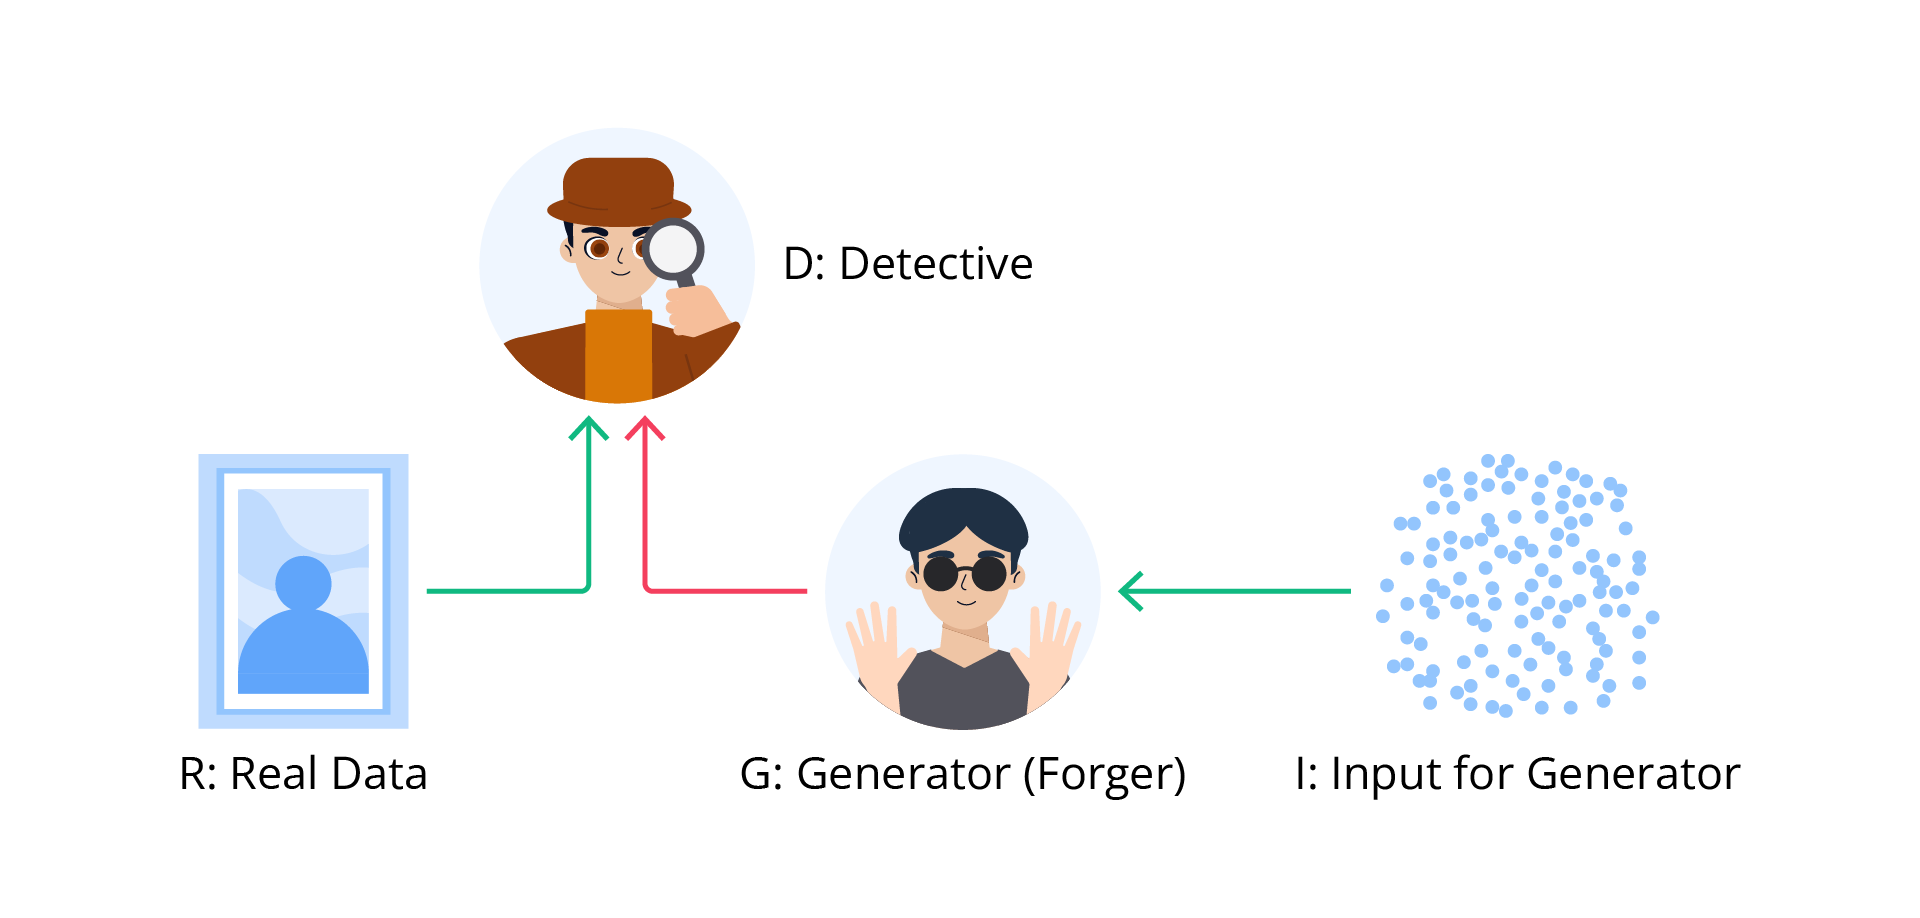

### Class Initialization

In [36]:
generator = Generator()
discriminator = Discriminator()

### Optimizer and loss function

In [37]:
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)
 
# Loss function
adversarial_loss = nn.BCELoss()

### Training

In [38]:
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)
    
        real_imgs = imgs
    
        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()
    
        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
    
    print(f'Epoch {epoch + 1}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

Epoch 1/50, D Loss: 0.019594332203269005, G Loss: 4.049464702606201
Epoch 2/50, D Loss: 0.4031490683555603, G Loss: 1.7245526313781738
Epoch 3/50, D Loss: 0.12246793508529663, G Loss: 3.1891257762908936
Epoch 4/50, D Loss: 0.241708904504776, G Loss: 3.4303903579711914
Epoch 5/50, D Loss: 0.06406418979167938, G Loss: 2.975768804550171
Epoch 6/50, D Loss: 0.03224799782037735, G Loss: 3.9963126182556152
Epoch 7/50, D Loss: 0.027001814916729927, G Loss: 4.307567119598389
Epoch 8/50, D Loss: 0.1533927321434021, G Loss: 4.4073920249938965
Epoch 9/50, D Loss: 0.04924701154232025, G Loss: 4.788715362548828
Epoch 10/50, D Loss: 0.08089815825223923, G Loss: 3.4228200912475586
Epoch 11/50, D Loss: 0.09904337674379349, G Loss: 3.540221929550171
Epoch 12/50, D Loss: 0.05032947286963463, G Loss: 3.9858551025390625
Epoch 13/50, D Loss: 0.06681684404611588, G Loss: 5.519556045532227
Epoch 14/50, D Loss: 0.14847351610660553, G Loss: 4.527659893035889
Epoch 15/50, D Loss: 0.14827606081962585, G Loss: 3.

- for i, (imgs, _) in enumerate(train_loader): 
    - perulangan data sejumlah satu batch. 
    - train_loader adalah DataLoader yang memuat data pelatihan. 
    - Dan imgs adalah batch gambar, 
    - dan _ mengabaikan label yang tidak diperlukan untuk pelatihan GAN.
- valid = torch.ones(imgs.size(0), 1): 
    - membuat tensor valid dengan nilai 1 untuk menunjukkan gambar asli. 
    - Ukuran batch adalah imgs.size(0) dengan satu kolom (1).
- fake = torch.zeros(imgs.size(0), 1): 
    - membuat tensor fake dengan nilai 0 untuk menunjukkan gambar palsu. 
    - Ukuran batch adalah imgs.size(0) dengan satu kolom (1).
- real_imgs = imgs: 
    - menyimpan gambar asli ke variabel real_imgs.
- Melatih Generator:
    - optimizer_G.zero_grad(): 
        - mengatur gradien dari semua parameter generator menjadi nol sebelum backward pass untuk mencegah akumulasi gradien dari batch sebelumnya.
    - z = torch.randn(imgs.size(0), latent_dim): 
        - membuat tensor z yang berisi noise acak dari distribusi normal. 
        - Dimensi z adalah (batch_size, latent_dim), di mana latent_dim adalah dimensi dari ruang laten.
    - gen_imgs = generator(z): 
        - menghasilkan gambar palsu dari noise acak z menggunakan kelas generator yang telah dibuat sebelumnya.
    - g_loss = adversarial_loss(discriminator(gen_imgs), valid): 
        - bertugas untuk menghitung kerugian (loss) untuk generator. 
        - Generator berusaha membuat gambar palsu yang terlihat seperti gambar asli sehingga Discriminator menganggapnya sebagai valid (asli). 
        - Di lain sisi discriminator(gen_imgs) memberikan output probabilitas untuk gambar palsu, dan adversarial_loss menghitung kerugian dengan membandingkan output ini dengan nilai 1 (asli).
    - g_loss.backward(): 
        - melakukan metode backward pass untuk menghitung gradien kerugian g_loss terhadap parameter generator.
    - optimizer_G.step():
        - memperbarui parameter generator berdasarkan gradien yang telah dihitung.
- Melatih Discriminator:
    - optimizer_D.zero_grad(): 
        - mengatur nilai gradien dari semua parameter discriminator ke nol sebelum melakukan backward pass untuk mencegah akumulasi gradien dari batch sebelumnya.
    - real_loss = adversarial_loss(discriminator(real_imgs), valid):
        - menghitung kerugian (loss) untuk discriminator saat memproses gambar asli.
        - discriminator(real_imgs) memberikan output probabilitas untuk gambar asli, 
        - adversarial_loss menghitung kerugian dengan membandingkan output ini dengan tensor valid.
    - fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake):
        - menghitung kerugian untuk discriminator saat memproses gambar palsu atau sintetis. 
        - discriminator(gen_imgs.detach()) memberikan output probabilitas untuk gambar palsu, dan 
        - adversarial_loss menghitung kerugian dengan membandingkan output ini dengan tensor fake. 
        - Selain itu, gen_imgs.detach() digunakan untuk menghentikan perhitungan backpropagation melalui generator, karena kita hanya ingin memperbarui parameter discriminator pada langkah ini.
    - d_loss = (real_loss + fake_loss) / 2: 
        - menghitung kerugian rata-rata dengan mengambil rata-rata kerugian berdasarkan gambar asli dan gambar palsu.
    - d_loss.backward(): 
        - melakukan backward pass untuk menghitung gradien kerugian d_loss terhadap parameter discriminator.
    - optimizer_D.step(): 
        - memperbarui parameter discriminator berdasarkan gradien yang telah dihitung.
    - print(f'Epoch {epoch + 1}/{num_epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}'): 
        - mencetak kondisi pelatihan setiap epoch, termasuk kerugian discriminator (d_loss) dan kerugian generator (g_loss). 
        - Lalu, d_loss.item() dan g_loss.item() digunakan untuk mendapatkan nilai skalar dari tensor kerugian.

Kode di atas melatih GAN sejumlah epoch yang sudah ditentukan, di mana pada setiap epoch generator dan discriminator dilatih secara bergantian menggunakan data dari setiap batch train_loader. Generator dilatih untuk menghasilkan gambar yang terlihat asli, sementara discriminator dilatih untuk membedakan antara gambar asli dan gambar palsu. Proses ini berulang hingga semua epoch selesai. Kurang lebih gambaran kedua komponen utama GAN akan bekerja seperti berikut.

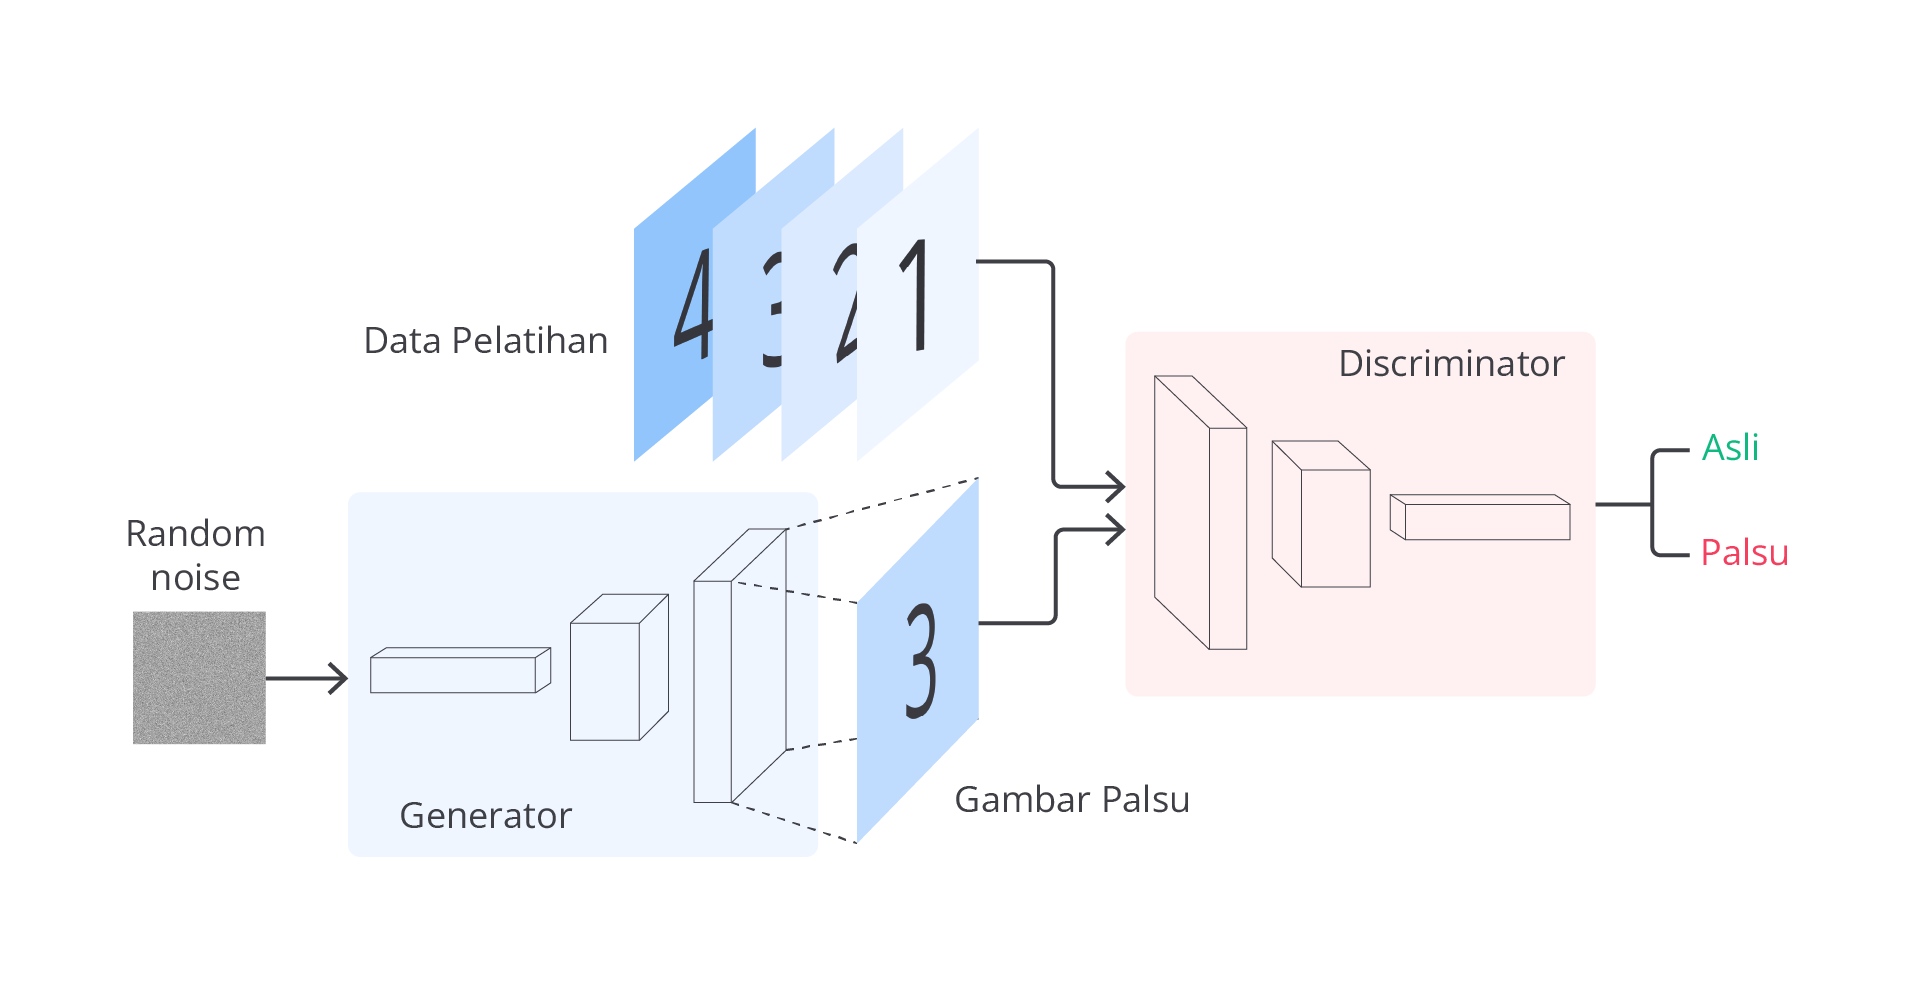
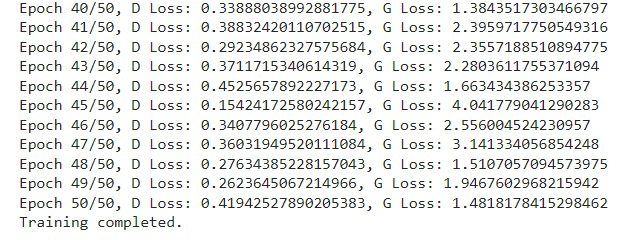


### Generate new images

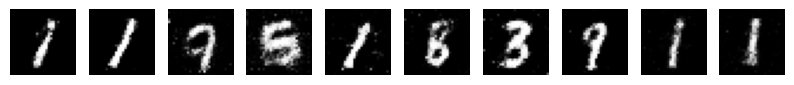

In [39]:
# Generate new images
def generate_images(generator, num_images, latent_dim):
    # Menentukan status generator menjadi evaluation mode
    generator.eval()
    
    # Generate random noise
    z = torch.randn(num_images, latent_dim)
    
    # Generate images from noise
    gen_imgs = generator(z)
    
    # Rescale images menjadi rentang [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1))
    for i in range(num_images):
        axs[i].imshow(gen_imgs[i].detach().numpy().squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()
    
# Generate dan menampilkan 10 gambar baru
generate_images(generator, 10, latent_dim)

## Diffusion Models

Difusi mengacu pada proses mengubah sinyal terstruktur (gambar) menjadi noise acak sedikit demi sedikit. Dengan menggunakan metode difusi, kita dapat menghasilkan noise dari gambar yang sudah ada. Lalu, kita juga dapat melatih jaringan saraf untuk mencoba menghilangkan noise tersebut. Dengan menggunakan jaringan yang telah dilatih, kita dapat menyimulasikan kebalikan dari difusi, yaitu reverse diffusion yang merupakan proses menghasilkan gambar dari noise.

[video.mp4](PengembanganMachineLearning/generativeAI/attachment/m9_27.mp4)

Secara singkat model ini memanfaatkan proses difusi dan denoising untuk belajar dan menghasilkan data.

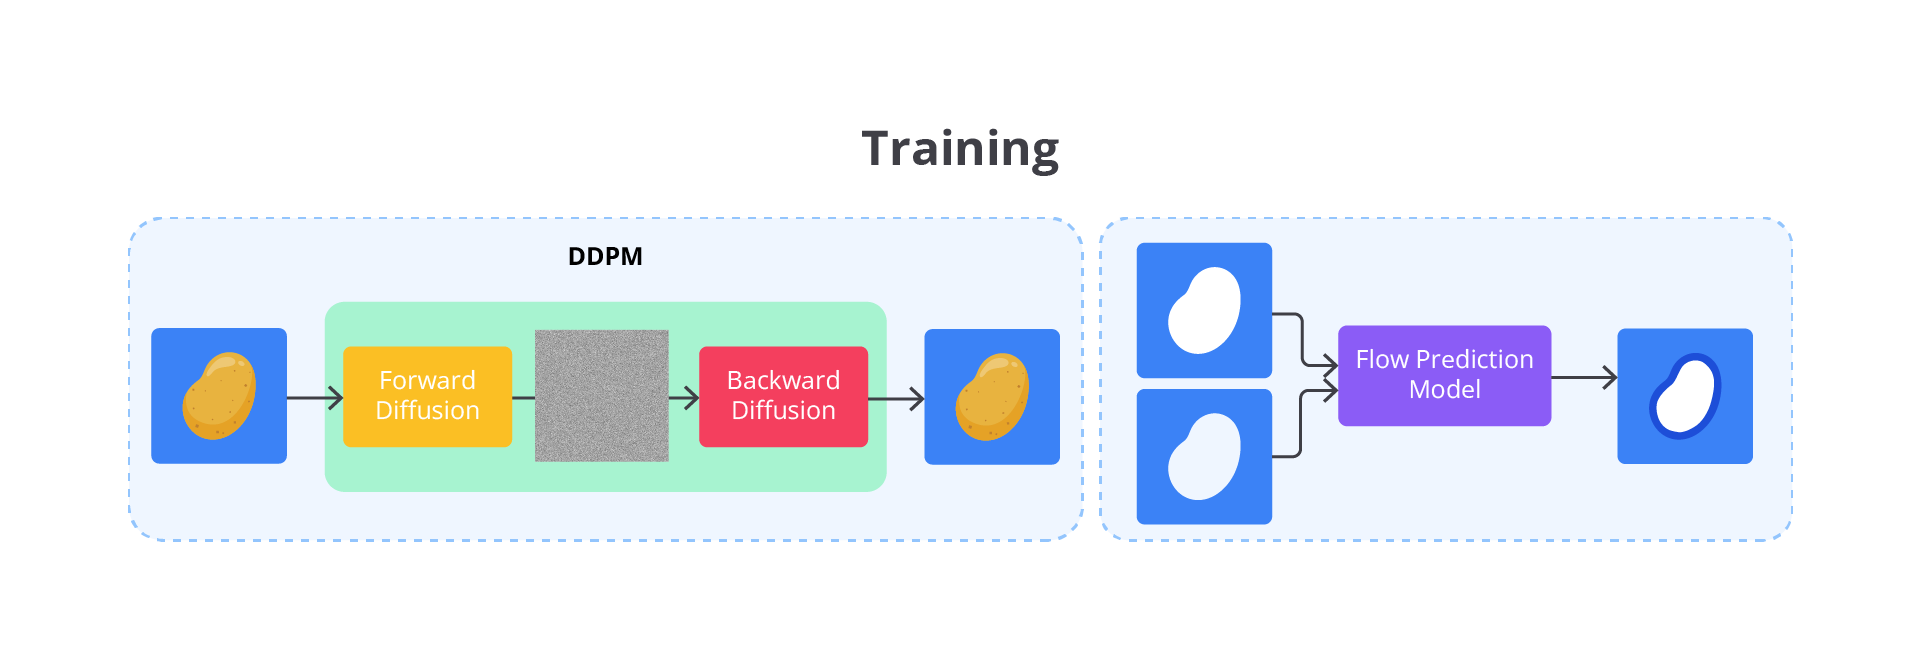

Stable Diffusion adalah model generatif berbasis difusi yang digunakan untuk menghasilkan gambar. Model ini dirancang untuk mengubah teks menjadi gambar dan melakukan modifikasi atau menciptakan gambar berdasarkan input teks. 

### Instalation

In [41]:
# Menggunakan local environment
!nvidia-smi
# Menggunakan Google Colab
# !nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


- diffusers: library dari Hugging Face yang fokus pada model difusi, termasuk Stable Diffusion, untuk menghasilkan gambar atau data lainnya. 
- accelerate: library ini dikembangkan oleh Hugging Face untuk memudahkan akselerasi dan pengaturan pelatihan model pada berbagai perangkat keras (CPU, GPU, TPU) dengan minimal perubahan kode.
- transformers: library utama dari Hugging Face yang menyediakan berbagai model transformer pra-latih untuk tugas-tugas NLP seperti teks klasifikasi, teks generasi, dan penerjemahan.
- bitsandbytes: library yang mengoptimalkan penggunaan memori dan komputasi dalam pelatihan model deep learning.
- safetensors: digunakan untuk menyimpan dan memuat tensor dalam proyek machine learning dengan keamanan tambahan karena akan menyimpan data tensor (data multidimensi yang digunakan dalam machine learning).
- xformers: bertugas untuk meningkatkan performa model transformer dalam pelatihan dan inferensi.
- jax: library untuk melakukan komputasi numerik yang memungkinkan penulisan kode Python yang berjalan dengan cepat pada CPU dan GPU. 
- jaxlib: library pendukung untuk jax yang menyertakan implementasi low-level dari operasi yang dipercepat oleh Accelerated Linear Algebra (XLA) dan menyediakan binding ke perangkat keras untuk komputasi dengan lebih efisien. 

In [64]:
!pip show diffusers


Name: diffusers
Version: 0.27.2
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/diffusers/graphs/contributors)
Author-email: patrick@huggingface.co
License: Apache 2.0 License
Location: /home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/genAI-venv/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, importlib-metadata, numpy, Pillow, regex, requests, safetensors
Required-by: 


### Import library

In [62]:
pip install diffusers==0.27.2 huggingface_hub==0.30.1



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [65]:
# import torch 
# from diffusers import StableDiffusionPipeline
# from PIL import Image
# import matplotlib.pyplot as plt

import torch
from diffusers import StableDiffusionPipeline

from PIL import Image
import matplotlib.pyplot as plt

ImportError: cannot import name 'DIFFUSERS_SLOW_IMPORT' from 'diffusers.utils' (/home/nadia/Documents/non-kuliah/CODINGCAMP/MachineLearningPlayGround/genAI-venv/lib/python3.10/site-packages/diffusers/utils/__init__.py)

### Data loading

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)

- StableDiffusionPipeline.from_pretrained akan mengunduh model CompVis/stable-diffusion-v1-4 dari repositori Hugging Face Model Hub termasuk model difusi, tokenizer, dan konfigurasi.
- Model dimuat dengan precision 16-bit floating point (torch.float16), yang efisien dalam hal memori dan kecepatan komputasi saat dijalankan di GPU. 
- Pipeline yang diinisialisasi akan disimpan pada variabel pipe yang dapat digunakan untuk menjalankan tugas-tugas generatif, seperti mengubah deskripsi teks menjadi gambar dengan menggunakan model Stable Diffusion.

menentukan cuda sebagai komponen utama untuk menjalankan pipeline di atas

In [ ]:
pipe = pipe.to('cuda')

Setelah itu, kita perlu mengoptimalkan penggunaan memori dan meningkatkan efisiensi komputasi ketika menggunakan model yang cukup besar, tetapi memiliki spesifikasi menengah.

In [ ]:
pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

Langkah terakhir yang perlu kita perhatikan adalah safety checker. Fungsi ini bertugas untuk memastikan gambar yang dihasilkan tidak hitam sepenuhnya.

### Crucial Parameters

ada beberapa parameter krusial yang perlu diatur agar dapat menghasilkan gambar sesuai dengan ekspektasi. 
Parameter tersebut dapat Anda sesuaikan dengan target dan kualitas gambar yang dihasilkan mulai dari :
- Prompt, 
- Seed, 
- Inference Step, 
- Guidance Scale, 
- Image Size dan 
- Negative Prompt. 

#### Prompt
Prompt adalah teks yang Anda berikan sebagai input ke model untuk menghasilkan gambar. Ini bisa berupa deskripsi, kalimat, atau kata kunci yang menggambarkan apa yang Anda ingin hasilkan dari model.
Model Stable Diffusion menggunakan prompt ini untuk memahami apa yang harus dihasilkan. Semakin jelas dan detail prompt-nya, semakin baik model dapat memahami dan menghasilkan gambar yang sesuai dengan deskripsi tersebut.

In [ ]:
prompt = 'a dog using combat machete to war, full HD'
img = pipe(prompt).images[0]

#### Seed
Seed adalah angka yang digunakan untuk menginisialisasi generator angka acak. Ini memastikan bahwa hasil dari proses generatif dapat direproduksi mirip setiap dijalankan.
Dengan menetapkan seed yang sama, Anda dapat menghasilkan gambar yang sama (mirip) dari prompt yang sama. Ini sangat berguna untuk eksperimen dan debugging, di mana konsistensi hasil sangat penting.

In [ ]:
seed = 2000generator = torch.Generator('cuda').manual_seed(seed)
img = pipe(prompt, generator=generator).images[0]
img

#### Guidance Scale
Guidance scale adalah parameter yang mengontrol seberapa kuat model harus mengikuti prompt yang diberikan.
Nilai guidance scale yang yang tinggi akan menghasilkan gambar yang memiliki gaya artistik, sedangkan semakin rendah nilai gambar akan semakin realistis atau mirip dengan data yang sudah dipelajari. Biasanya rentang guidance scale berada di 6 hingga 20.

In [ ]:
plt.figure(figsize=(18,8))for i in range(1, 6):
    
    n_guidance = i + 3
    generator = torch.Generator("cuda").manual_seed(seed)
    img = pipe(prompt, guidance_scale=n_guidance, generator=generator).images[0]
    
    plt.subplot(1,5,i)
    plt.title('guidance_scale: {}'.format(n_guidance))
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

#### Inference Step
Inference steps mengacu pada jumlah langkah yang diambil oleh model Stable Diffusion selama proses generasi gambar. Ini adalah jumlah iterasi yang digunakan oleh model untuk menghapus noise dan secara bertahap membentuk gambar akhir dari input acak berdasarkan prompt yang diberikan.

Jumlah inference steps yang lebih tinggi biasanya menghasilkan gambar dengan kualitas yang lebih baik karena model memiliki lebih banyak kesempatan untuk menghapus noise dan memperbaiki detail gambar. Namun, lebih banyak langkah juga berarti waktu komputasi yang lebih lama. By defaultangka dari inference step adalah 50 sehingga untuk menghasilkan gambar sesuai dengan keinginan,.

Jadi, semakin besar nilai inference stepnya, model akan menghasilkan gambar yang lebih jelas.

In [ ]:
prompt = "A man using baby shark costume at the moon"
generator = torch.Generator("cuda")
img = pipe(prompt, num_inference_steps=999, generator=generator).images[0]
img

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(18,8))
for i in range(1, 10):
    n_steps = i * 1
    #print(n_steps)
    generator = torch.Generator('cuda')
    img = pipe(prompt, num_inference_steps=n_steps, generator=generator).images[0]
    
    plt.subplot(1, 10, i)
    plt.title('num_inference_steps: {}'.format(n_steps))
    plt.imshow(img)
    plt.axis('off')
plt.show()

#### Image Size
Image size adalah ukuran gambar yang dihasilkan oleh model. Ini biasanya ditentukan dalam piksel dan bisa berupa ukuran lebar dan tinggi (width x height).
Ukuran gambar memengaruhi jumlah komputasi yang diperlukan. Gambar yang lebih besar membutuhkan lebih banyak memori dan waktu komputasi. Biasanya, ukuran gambar ditentukan berdasarkan kebutuhan spesifik aplikasi atau keterbatasan perangkat keras.

#### Negative Prompt
Negative prompt adalah teks yang Anda tentukan untuk menentukan apa yang tidak ingin dihasilkan dalam gambar. Ini membantu model menghindari elemen-elemen tertentu yang melanggar etika ataupun perlu dihindari.
Dengan memberikan negative prompt, Anda dapat mengarahkan model untuk menghindari menghasilkan elemen atau fitur tertentu yang tidak diinginkan dalam gambar. Ini berguna untuk mendapatkan hasil yang lebih sesuai dengan preferensi atau kebutuhan tertentu.

In [ ]:
num_images = 5 
prompt = 'a man enjoying sunset at bali beach with his girlfriend'
neg_prompt = 'coconut, knife, straw, building'
    
    
imgs = pipe(prompt, negative_prompt = neg_prompt, num_images_per_prompt=num_images).images
grid = grid_img(imgs, rows = 1, cols = 5, scale=0.75)
grid

Ada tiga hal penting yang perlu Anda perhatikan dalam penggunaan parameter tersebut.

- Kombinasi Parameter: 
    - pengaturan yang optimal dari parameter-parameter tersebut bergantung pada tujuan spesifik dan keterbatasan perangkat keras yang Anda miliki. 
    - Misalnya, untuk menghasilkan gambar berkualitas tinggi pada perangkat keras dengan memori terbatas, Anda mungkin perlu menyeimbangkan antara ukuran gambar dan jumlah inference steps.
- Eksperimen: 
    - menggunakan berbagai kombinasi dari parameter ini dan mengevaluasi hasilnya adalah cara terbaik untuk menemukan pengaturan yang menghasilkan gambar terbaik sesuai kebutuhan Anda.
- Reproduksi: 
    - menggunakan seed memungkinkan hasil yang dapat direproduksi sehingga berguna untuk eksperimen dan debugging.